In [ ]:
"""
Regression Discontinuity Design (RDD) on Student Performance via Scholarship Eligibiilty
---

🔍 **Situation**:
    A university awards a merit-based scholarship to students who score 80 or higher
    on their entrance exam. We want to determine whether receiving the scholarship has
    a causal impact on final GPA using a Regression Discontinuity Design (RDD).

📌 **Task**:
    Estimate the jump in final GPA at the scholarship eligibility cutoff (exam score = 80)
    using an RDD framework. The goal is to measure the true effect of the
    scholarship by comparing students just above and below the threshold.

✨ **Action**: 
    Centered the exam score around the threshold (x = exam_score - 80).
    Applied local linear regression with an interaction term.
    Used the causalpy package to estimate the discontinuity at the threshold.

📈 **Result**:
    Receiving the scholarship increases final GPA by 0.38 (94% HDI [0.31, 0.45]).
    The baseline GPA (for students at the threshold) is 4.9.
    The GPA trend is slightly weaker for scholarship recipients, suggesting diminishing returns at higher scores.
    The standard deviation of GPA is 0.2, showing moderate variability.

🚀 Next Steps / Additional Analysis
    Placebo Tests: Check for discontinuities at non-policy cutoffs.
    Bandwidth Sensitivity: Test different windows around the cutoff.
    Covariate Adjustments: Control for other factors like socioeconomic status.

✍ **Author**: Justin Wall
📅 **Updated**: 03/12/2025
"""

'\nRegression Discontinuity Design (RDD) on Student Performance via Scholarship Eligibiilty\n---\n\n🔍 **Situation**:\n\n📌 **Task**:\n\n✨ **Action**: \n\n📈 **Result**:\n\n🚀 Next Steps / Additional Analysis\n\n\n✍ **Author**: Justin Wall\n📅 **Updated**: 03/12/2025\n'

In [5]:
# =================================
# Import Libraries and Create Data
# =================================
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import causalpy as cp

# Seed for reproducibility
np.random.seed(42)

# Generate exam scores (continuous running variable)
n = 500
exam_score = np.random.uniform(60, 100, n)

# Scholarship eligibility based on the cutoff (80)
scholarship = (exam_score >= 80).astype(int)

# Introduce a discontinuous jump in GPA for those who get the scholarship
base_gpa = 2.5 + 0.03 * exam_score  # Baseline GPA trend
treatment_effect = 0.4  # Effect of scholarship on GPA
noise = np.random.normal(0, 0.2, n)

# Final GPA with a discontinuity at the cutoff
final_gpa = base_gpa + (scholarship * treatment_effect) + noise

# Create the DataFrame
data = pd.DataFrame({
    'exam_score': exam_score,
    'scholarship': scholarship,
    'final_gpa': final_gpa
})

data.head()

# Exam Score: Entrance exam score (ranging from 60 to 100)
# Scholarship: Binary variable indicating scholarship eligibility (1: eligible, 0: not eligible) (exam score >= 80)
# Final GPA: Final GPA of the student after one year of study
#%%

,exam_score,scholarship,final_gpa
0,74.981605,0,4.817799
1,98.028572,1,6.216091
2,89.279758,1,5.768477
3,83.946339,1,5.303009
4,66.240746,0,4.307539


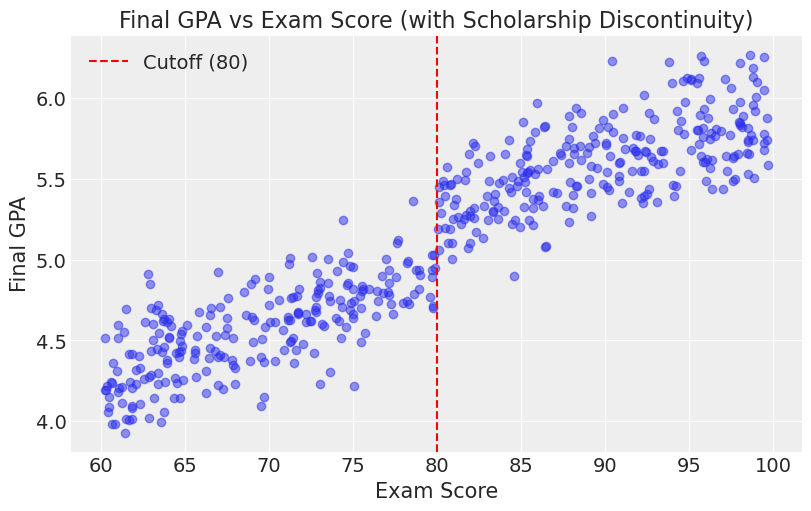

In [6]:
# ==========================
# Visualizing the Data
# ==========================
#%%
# Visualizing the data
plt.figure(figsize=(8, 5))
plt.scatter(data['exam_score'], data['final_gpa'], alpha=0.5)
plt.axvline(x=80, color='red', linestyle='--', label='Cutoff (80)')
plt.title("Final GPA vs Exam Score (with Scholarship Discontinuity)")
plt.xlabel("Exam Score")
plt.ylabel("Final GPA")
plt.legend()
plt.show()
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


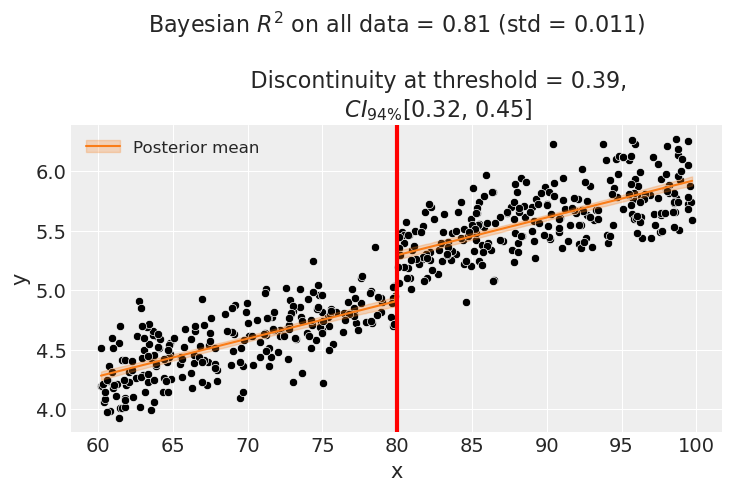

In [23]:
# ==========================
# RDD Analysis
# ==========================
#%%
# Rename scholarship column to treated
df = data.rename(columns={'scholarship': 'treated','exam_score':'x', 'final_gpa':'y'})
df['treated'] = df['treated'].astype(bool)
# df = cp.load_data("rd")
# Run RDD
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated",
    model=cp.pymc_models.LinearRegression(),
    treatment_threshold=80,
)

fig, ax = result.plot()
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


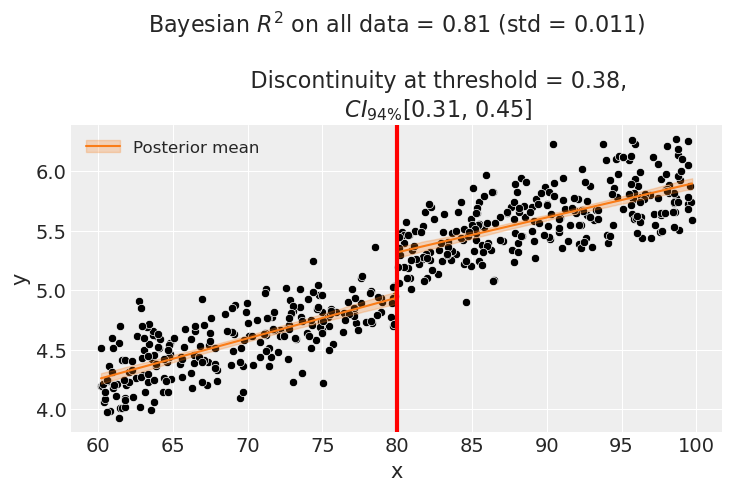

In [24]:
# ==========================
# RDD Analysis w/ Interaction
# ==========================
#%%
# Run RDD
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(),
    treatment_threshold=80,
)

fig, ax = result.plot()
#%%

Interpreting results
- Estimated Treatment Effect: The size of the jump in GPA at the cutoff: 0.38
- Credible Intervals 94%: These tell us how precise our estimate is: 0.31 to 0.45: so pretty decent!

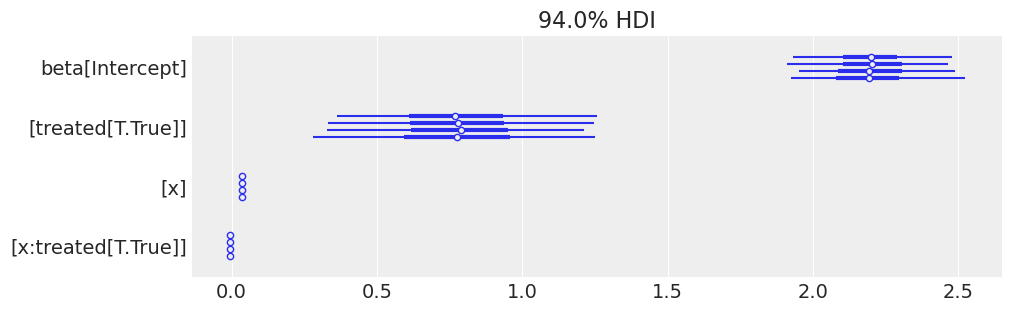

In [25]:
az.plot_forest(result.idata.posterior, var_names="beta", figsize=(10, 3));

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


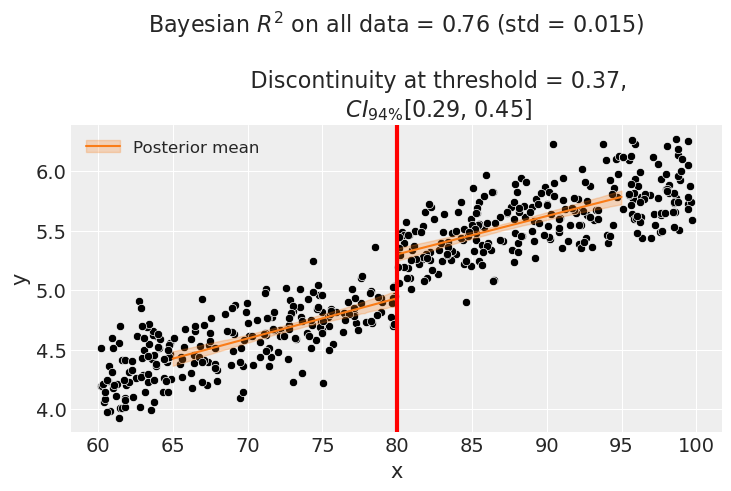

In [17]:
# ==========================
# RDD Analysis w/bandwidth
# ==========================
#%%
# Run RDD w/bandwidth
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(),
    treatment_threshold=80,
    bandwidth=15,
)

fig, ax = result.plot()
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


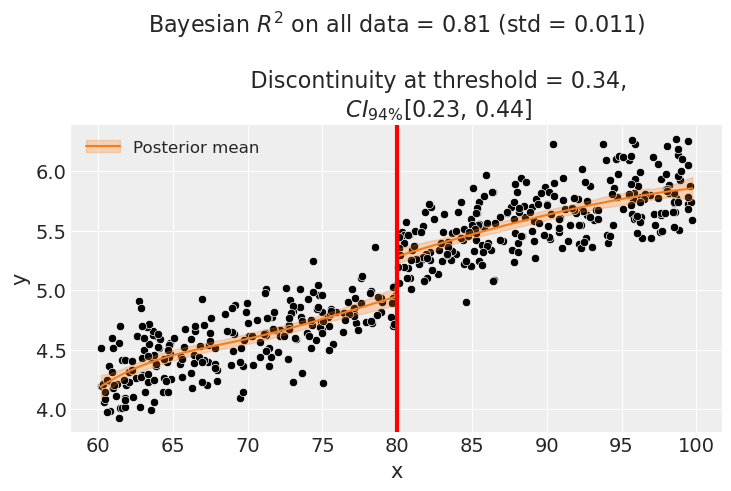

In [18]:
# ==========================
# RDD Analysis w/basis splines
# ==========================
#%%
# Run RDD w/bandwidth
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(),
    treatment_threshold=80,
)

fig, ax = result.plot()
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


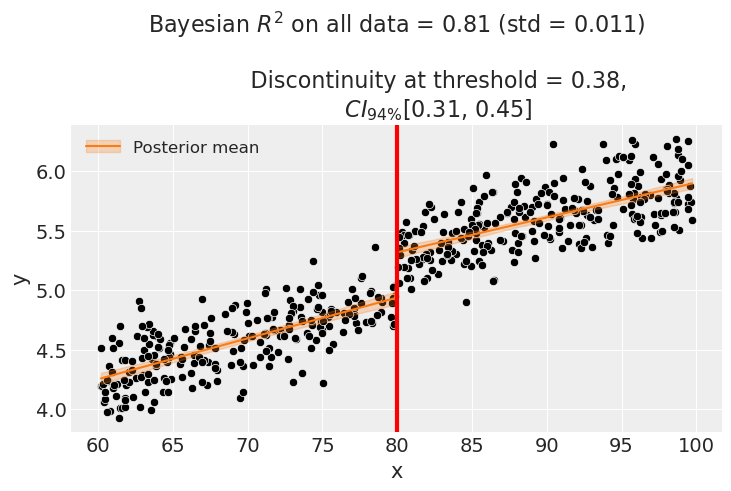

In [20]:
# ==========================
# RDD Analysis w/target accept
# ==========================
#%%
# Run RDD w/bandwidth
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"target_accept": 0.95,}),
    treatment_threshold=80,
)

fig, ax = result.plot()
#%%

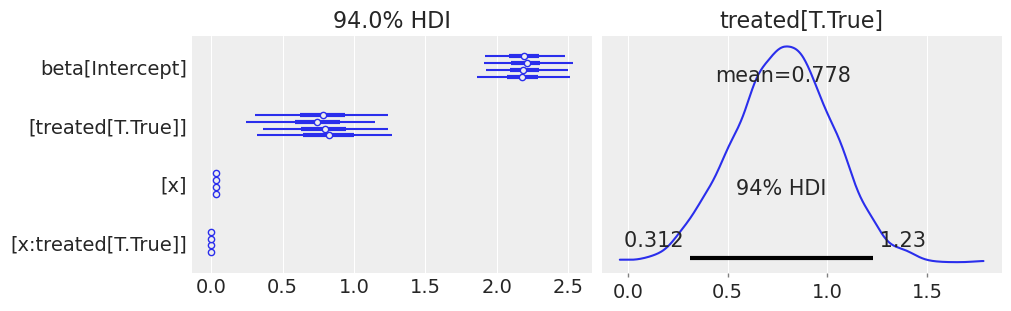

In [21]:
# ==========================
# Plot Posterior Distribution
# ==========================
#%%
import arviz as az
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

az.plot_forest(result.idata.posterior, var_names="beta", ax=ax[0])
az.plot_posterior(
    result.idata.posterior.beta.sel(coeffs="treated[T.True]"),
    round_to=3,
    ax=ax[1],
)

ax[1].set(title="treated[T.True]");
#%%

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


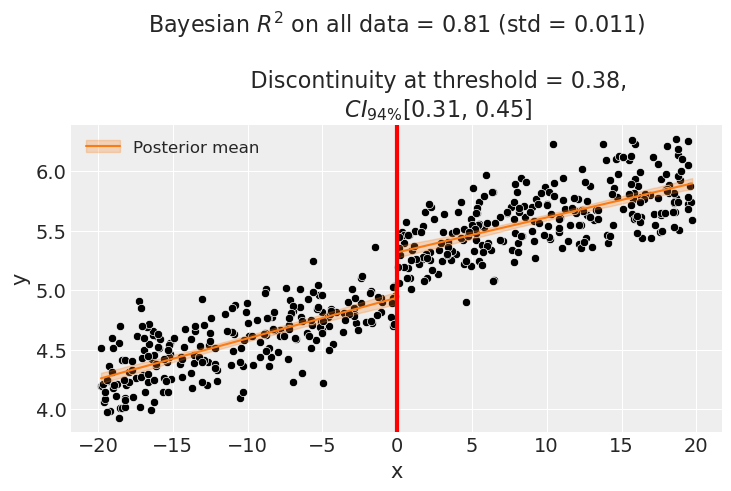

In [28]:
# ==========================
# Center the Data
# ==========================
#%%
# Center the data
df = data.rename(columns={'scholarship': 'treated','exam_score':'x', 'final_gpa':'y'})
df['treated'] = df['treated'].astype(bool)
df['x'] = df['x'] - 80

# Run RDD
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(),
    treatment_threshold=0,
)

fig, ax = result.plot()
#%%

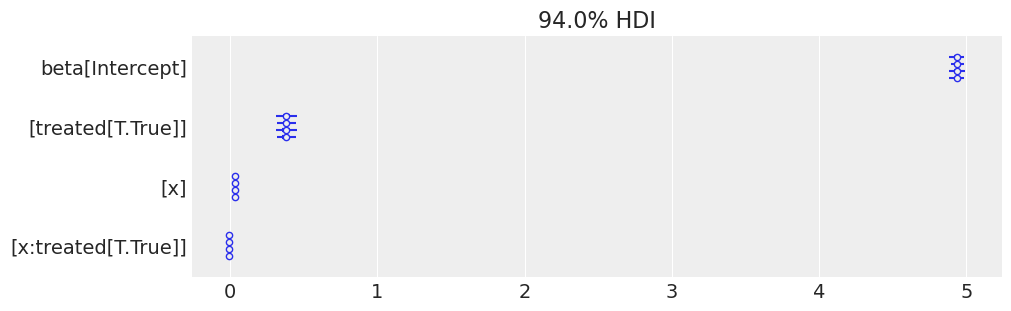

In [29]:
az.plot_forest(result.idata.posterior, var_names="beta", figsize=(10, 3));

In [30]:
# ==========================
# Model Summary
# ==========================
#%%
result.summary()
#%%

Difference in Differences experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0

Results:
Discontinuity at threshold = 0.38$CI_{94\%}$[0.31, 0.45]


Model coefficients:
    Intercept          4.9, 94% HDI [4.9, 5]
    treated[T.True]    0.38, 94% HDI [0.31, 0.45]
    x                  0.034, 94% HDI [0.03, 0.038]
    x:treated[T.True]  -0.0048, 94% HDI [-0.011, 0.0011]
    sigma              0.2, 94% HDI [0.19, 0.21]


***